<a href="https://colab.research.google.com/github/winter2897/Airsim-UAV-indoor-obstacle-avoidance-based-on-AI-technique-with-an-ensemble-of-ResNet8-and-Res-DQN/blob/master/ResNet_UAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE')
!ls

Array_dataset  dataset_02    resnet08_ase.png	  ResNet_v3.ipynb
Array_path     dataset.zip   resnet_block.drawio  ResNet_v4.ipynb
Back_Up        model	     resnet_block.png	  ResNet_v5.ipynb
dataset        plot_figs     ResNet_v1.ipynb	  test
dataset_01     resnet08_ase  ResNet_v2.ipynb	  VGG.ipynb


In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/data.zip"

In [ ]:
#import thu vien:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input, Activation
from keras import regularizers 
from keras.utils import np_utils
from keras.layers.merge import add

In [ ]:
# viet ham:
# Kích thước ảnh cho input của model
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 72, 128, 3

#1 ham sua nhan ve 0: di thang; 1: re trai; 2: re phai
def fix_label (y):
  for i in range(0, len(y)):
    if y[i] == 0:
      y[i] = 0
    elif y[i] < 0:
      y[i] = 1
    else :
      y[i] = 2
  return y
#2 chuyen doi tu rgba (4 chieu) sang rgb (3 chieu):
def rgba_to_rgb(img_path):
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
  return image
#3 chuyen doi tu rgb sang gray:
def rgb_to_gay(img_path):
  image = cv2.imread
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return image
#4 resize anh:
def resize(image):
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
#6 Doc anh tu dataset:
def read_imgs(data):
  """
  Doc anh tu dataset
  """
  array_imgs=[]
  for i in data:
    # print('dataset/'+i[0])
    img = np.array(cv2.imread('dataset_02/'+i[0]))
    img = resize(img)
    array_imgs.append(img)
  return np.array(array_imgs)/255
#7 copy dataset:
def copy_dataset(data):
  a = data
  for i in range(10): #old 30
    b = data
    a = np.append(a, b, axis=0)
  return a


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(72, 128, 3)


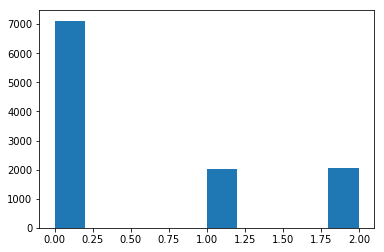

In [ ]:
#Thu muc luu dataset:
data_dir = '/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/dataset'
#Doc file csv voi cac title tuong ung:
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'data.csv'),
                      names=['imgs', 'v_x', 'v_y', 'v', 'steering'])

# data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'data.csv'),
#                       names=['imgs','v', 'steering'])
# Lấy đường dẫn đến ảnh
X = data_df[['imgs']].values
X = read_imgs(X)
X = copy_dataset(X)
# Lấy góc lái của drone
y = data_df['steering'].values
fix_label(y)
y = copy_dataset(y)
Y_one_hot = np_utils.to_categorical(y, 3)
# Vẽ histogram dữ liệu
plt.hist(y)
print(Y_one_hot)
print(X[0].shape)

In [ ]:
print('Dữ liệu y ban đầu: ', y[1])
print('Dữ liệu y sau one-hot encoding: ',Y_one_hot[1])
print('Shape của nhãn:',Y_one_hot.shape)
print('Shape của dataset:',X.shape)

Dữ liệu y ban đầu:  1.0
Dữ liệu y sau one-hot encoding:  [0. 1. 0.]
Shape của nhãn: (11198, 3)
Shape của dataset: (11198, 72, 128, 3)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y_one_hot, test_size=0.2, random_state=0)
print(X_train.shape)
y_train.shape

(8958, 72, 128, 3)


(8958, 3)

In [ ]:
def resnet8(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS):
  INPUT_SHAPE = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
  x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same')(INPUT_SHAPE)
  x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(x1)
      # First residual block: RES BLOCK 1
  x2 = keras.layers.normalization.BatchNormalization()(x1)
  x2 = Activation('relu')(x2)
  x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
       kernel_initializer="he_normal",
       kernel_regularizer=regularizers.l2(1e-4))(x2)

  x2 = keras.layers.normalization.BatchNormalization()(x2)
  x2 = Activation('relu')(x2)
  x2 = Conv2D(32, (3, 3), padding='same',
       kernel_initializer="he_normal",
       kernel_regularizer=regularizers.l2(1e-4))(x2)

  x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same')(x1)
  x3 = add([x1, x2])

      # Second residual block: RES BLOCK 2
  x4 = keras.layers.normalization.BatchNormalization()(x3)
  x4 = Activation('relu')(x4)
  x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                  kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-4))(x4)

  x4 = keras.layers.normalization.BatchNormalization()(x4)
  x4 = Activation('relu')(x4)
  x4 = Conv2D(64, (3, 3), padding='same',
              kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(1e-4))(x4)

  x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same')(x3)
  x5 = add([x3, x4])

      # Third residual block: RES BLOCK 3
  x6 = keras.layers.normalization.BatchNormalization()(x5)
  x6 = Activation('relu')(x6)
  x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
              kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(1e-4))(x6)

  x6 = keras.layers.normalization.BatchNormalization()(x6)
  x6 = Activation('relu')(x6)
  x6 = Conv2D(128, (3, 3), padding='same',
              kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(1e-4))(x6)

  x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same')(x5)
  x7 = add([x5, x6])

      #Flatten 
  x8 = Flatten()(x7)
  x8 = Activation('relu')(x8)
  x8 = Dropout(0.5)(x8)
  
  x9 = Dense(512, activation = "relu")(x8)
  x9 = Dropout(0.5)(x9)
  result =  Dense(3, activation = 'softmax')(x9)

  model = Model(inputs=[INPUT_SHAPE], outputs=[result])
  print(model.summary())
  return model

model = resnet8(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 72, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 36, 64, 32)   2432        input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 17, 31, 32)   0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 17, 31, 32)   128         max_pooling2d_13[0][0]           
___________________________________________________________________________________________

In [ ]:
# Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức dùng để tối ưu hàm loss function.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Checkpoint
from keras.callbacks import ModelCheckpoint

model_file = "model/checkpoint/ResNet_08_v1_checkpoint.h5"
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Thực hiện train model với data
H = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
          batch_size=128, epochs=40, verbose=1, callbacks=callbacks_list, shuffle=1)

Train on 8958 samples, validate on 2240 samples
Epoch 1/40
8958/8958 [==============================] - 12s 1ms/step - loss: 0.8202 - acc: 0.7330 - val_loss: 0.5184 - val_acc: 0.8464

Epoch 00001: val_loss improved from inf to 0.51841, saving model to model/checkpoint/Rollback_ResNet_08_v1_2_checkpoint.h5
Epoch 2/40
8958/8958 [==============================] - 5s 520us/step - loss: 0.3780 - acc: 0.8804 - val_loss: 0.3483 - val_acc: 0.8946

Epoch 00002: val_loss improved from 0.51841 to 0.34831, saving model to model/checkpoint/Rollback_ResNet_08_v1_2_checkpoint.h5
Epoch 3/40
8958/8958 [==============================] - 5s 516us/step - loss: 0.2218 - acc: 0.9526 - val_loss: 0.2760 - val_acc: 0.9214

Epoch 00003: val_loss improved from 0.34831 to 0.27595, saving model to model/checkpoint/Rollback_ResNet_08_v1_2_checkpoint.h5
Epoch 4/40
8958/8958 [==============================] - 5s 517us/step - loss: 0.1602 - acc: 0.9751 - val_loss: 0.5074 - val_acc: 0.8612

Epoch 00004: val_loss did no

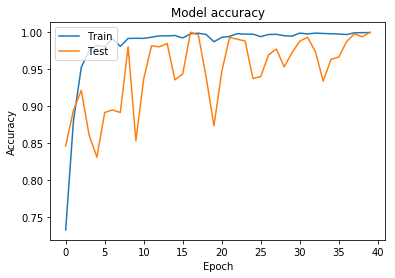

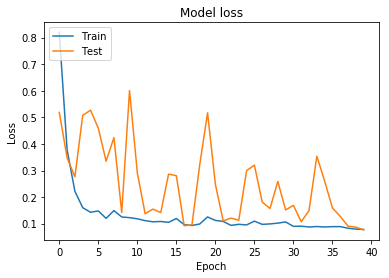

In [ ]:
fig1 = plt.figure()
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig1.savefig("plot_figs/Model_ResNet_08_v1_accuracy.png")

fig2 = plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig2.savefig("plot_figs/Model_ResNet_08_v1_loss.png")

In [ ]:
results = model.evaluate(x=X_valid, y=y_valid, batch_size=128, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print('Test loss: {0:.2f}'.format(results[0]))
print('Test accuracy: {0:.2f}%'.format(results[1]*100))

6312/6312 [==============================] - 2s 244us/step
Test loss: 0.11
Test accuracy: 99.89%


In [ ]:
import json
# lets assume `model` is main model 
model_json = model.to_json()
with open("model/ResNet_08_v1_checkpoint.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("model/ResNet_08_v1.h5.h5")

**Test**

In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json

with open('model/architecture/Improve_ResNet_08_v1_2_checkpoint.json','r') as f:
    model_json = json.load(f)

model = model_from_json(model_json)
model.load_weights('model/checkpoint/Improve_ResNet_08_v1_2_checkpoint.h5')

(200, 200, 3)
[[6.7197223e-04 9.9931991e-01 8.0908667e-06]]
Giá trị số :  1


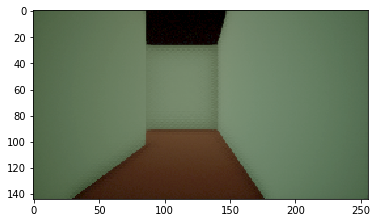

In [ ]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/testset/1.png')
plt.imshow(img)
img = resize(img)
print(img.shape)
img = np.array(img)/255
predictASE = model.predict(img.reshape(1,200,200,3))
print(predictASE)
print('Giá trị số : ', np.argmax(predictASE))
# print('Giá trị dự đoán: ', label_pre.get(np.argmax(predictASE)))

DỰ ĐOÁN KẾT QUẢ

In [ ]:
from sklearn.utils import shuffle

def read_imgs(data):
  array_imgs=[]
  for i in data:
    # print('dataset/'+i[0])
    img = np.array(cv2.imread('dataset_01/'+i[0]))
    img = resize(img)
    array_imgs.append(img)
  return np.array(array_imgs)/255


#8 test func:
def test_data(data_test_dir):
  test_dir = data_test_dir
  test_df = pd.read_csv(os.path.join(os.getcwd(), test_dir, 'data.csv'),
                        names=['imgs', 'v_x', 'v_y', 'v', 'steering'])
  
  # test_df = pd.read_csv(os.path.join(os.getcwd(), test_dir, 'data.csv'),
  #                     names=['imgs','v', 'steering'])
  # Lấy đường dẫn đến ảnh
  X = test_df[['imgs']].values
  X = read_imgs(X)
  # Lấy góc lái của drone
  y = test_df['steering'].values
  fix_label(y)
  Y_one_hot = np_utils.to_categorical(y, 3)
  return X, Y_one_hot

test_dir = '/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/testset'
test_img, test_label = test_data(test_dir)

In [ ]:
print(test_img.shape)
print(test_label.shape)

(345, 72, 128, 3)
(345, 3)


In [ ]:
#####call back model######
from keras.models import load_model
from keras.models import model_from_json
import json

with open('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/Back_Up/back_up_vat_can/Dronet_008_vatcan_model_in_json.json','r') as f:
    model_json = json.load(f)

model = model_from_json(model_json)
model.load_weights('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/Back_Up/back_up_vat_can/Dronet_008_vatcan_weights.h5')

In [ ]:
predictASE = model.predict(test_img[0].reshape(1, 72, 128, 3))
print(predictASE)
print(test_label[0])
print(np.argmax(predictASE))
print(np.argmax(test_label[0]))
print(test_label[0])

[[9.991429e-01 3.511935e-04 5.058228e-04]]
[1. 0. 0.]
0
0
[1. 0. 0.]


In [ ]:
test_img, test_label = X_valid, y_valid
print(test_img.shape)
print(test_label.shape)

(6312, 72, 128, 3)
(6312, 3)


In [ ]:
#####call back model######
from keras.models import load_model
from keras.models import model_from_json
import json

with open('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/Back_Up/back_up_vat_can/Dronet_008_vatcan_model_in_json.json','r') as f:
    model_json = json.load(f)
model = model_from_json(model_json)
model.load_weights('/content/drive/My Drive/Colab Notebooks/DroNet_V2_ASE/Back_Up/back_up_vat_can/Dronet_008_vatcan_weights.h5')

#####predict_data_test#####
import statistics 
a_0 =[] #thang
a_1 =[] #trai
a_2 =[] #phai
accuracy_on_test_set_point = 0
test = []
for index in range(0, len(test_img)):
  predictASE = model.predict(test_img[index].reshape(1, 72, 128, 3))
  #check label, get accuracy_point
  if np.argmax(predictASE) == np.argmax(test_label[index]):
    accuracy_on_test_set_point = accuracy_on_test_set_point + 1
    if np.argmax(predictASE) == 0:
      a_0.append(predictASE[0][0])
    if np.argmax(predictASE) == 1:
      a_1.append(predictASE[0][1])
    if np.argmax(predictASE) == 2:
      a_2.append(predictASE[0][2])

In [ ]:
accuracy = (accuracy_on_test_set_point/len(test_img))*100
A_0 = [min(a_0), max(a_0), np.mean(a_0)]
A_1 = [min(a_1), max(a_1), np.mean(a_1)]
A_2 = [min(a_2), max(a_2), np.mean(a_2)]

# ####print_result####
print("A_0:", A_0)
print("A_1:", A_1)
print("A_2:", A_2)
print("Accuracy:", accuracy, "%")


A_0: [0.9988211, 1.0, 0.9999677]
A_1: [0.9996792, 1.0, 0.99999404]
A_2: [0.99963117, 1.0, 0.99999046]
Accuracy: 100.0 %
